# BEE 4750 Homework 5: Mixed Integer and Stochastic Programming

**Name**: Bailey Belinger, Camila Monter, Priya Shah

**ID**: 5277347

> **Due Date**
>
> Thursday, 12/05/24, 9:00pm

## Overview

### Instructions

-   In Problem 1, you will use mixed integer programming to solve a
    waste load allocation problem.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [21]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Downloads/BEE4750/hw5-last-3-brain-cells-1`


In [22]:
using JuMP
using HiGHS
using DataFrames
using GraphRecipes
using Plots
using Measures
using MarkdownTables

## Problems (Total: 30 Points)

### Problem 1 (30 points)

Three cities are developing a coordinated municipal solid waste (MSW)
disposal plan. Three disposal alternatives are being considered: a
landfill (LF), a materials recycling facility (MRF), and a
waste-to-energy facility (WTE). The capacities of these facilities and
the fees for operation and disposal are provided below.

-   **LF**: Capacity 200 Mg, fixed cost \$2000/day, tipping cost
    \$50/Mg;
-   **MRF**: Capacity 350 Mg, fixed cost \$1500/day, tipping cost
    \$7/Mg, recycling cost \$40/Mg recycled;
-   **WTE**: Capacity 210 Mg, fixed cost \$2500/day, tipping cost
    \$60/Mg;

The MRF recycling rate is 40%, and the ash fraction of non-recycled
waste is 16% and of recycled waste is 14%. Transportation costs are
\$1.5/Mg-km, and the relative distances between the cities and
facilities are provided in the table below.

| **City/Facility** | **Landfill (km)** | **MRF (km)** | **WTE (km)** |
|:-----------------:|:-----------------:|:------------:|:------------:|
|         1         |         5         |      30      |      15      |
|         2         |        15         |      25      |      10      |
|         3         |        13         |      45      |      20      |
|        LF         |        \-         |      32      |      18      |
|        MRF        |        32         |      \-      |      15      |
|        WTE        |        18         |      15      |      \-      |

The fixed costs associated with the disposal options are incurred only
if the particular disposal option is implemented. The three cities
produce 100, 90, and 120 Mg/day of solid waste, respectively, with the
composition provided in the table below.

**Reminder**: Use `round(x; digits=n)` to report values to the
appropriate precision!

**In this problem**:

-   Formulate the waste load allocation problem and implement it in
    `JuMP`.
-   Draw a diagram showing the flows of waste between the cities and the
    facilities. Which facilities (if any) will not be used? Does this
    solution make sense?

In [42]:
I = 1:3
J = 1:3
K = 1:3

l = [5 30 15; 15 25 10; 13 45 20] # Distance between source i and disposal j (km)
a = 1.5 .* l # Cost of transporting waste from source i to disposal j ($/Mg-km)
c = [2000 1500 2500] # Fixed costs of operating disposal j ($/day)
b = [50 7 60] # Variable cost of disposing waste at disposal j ($/Mg)
MRF_recylcing_rate = 0.4 
MRF_recylcing_cost = 40
recycling = [0 (MRF_recylcing_rate * MRF_recylcing_cost) 0] # recycling costs at disposal j 
residuals = [0 32 18; 32 0 15; 18 15 0] # distance between facilities (km)
residual_cost = 1.5 .* residuals # Cost of transporting waste from disposal k to disposal j ($/Mg-km)
WTE_Residual_Ash = 0.16
production = [100 90 120] # solid waste production at each city i (Mg/day)
disposal_limit = [200 350 210] # capacity of each disposal j (Mg)

MSW_model = Model(HiGHS.Optimizer)

# Waste Management Decision Variables
@variable(MSW_model, W[i in I, j in J] >= 0)  # Waste transported from city i to disposal j (Mg/day)
@variable(MSW_model, R[k in K, j in J] >= 0)  # Residual waste transported from disposal k to disposal j (Mg/day)
@variable(MSW_model, Y[j in J] >= 0)  # Operational status (on/off) of disposal j (binary)

# Objective Functions 
transpo_cost = sum(a[i, j] * W[i, j] for i in I, j in J) + sum(residual_cost[i, j] * R[i, j] for i in I, j in J)
dispo_cost = sum(c[j] * Y[j] + sum(b[j] * W[i, j] for i in I) + sum(b[j] * R[k, j] for k in K) + sum(recycling[j] * W[i, j] for i in I) for j in J)
@objective(MSW_model, Min, sum(transpo_cost + dispo_cost))

# Constraints 
# Residual Flow Constraint
allowed_pairs = [(1, 3), (2, 3), (2, 1)]
# before: @constraint(MSW_model, residual_flow_contraint, [k in K, j in J; (k, j) ∉ allowed_pairs], R[k, j] == 0)
for k in K, j in J
    if (k, j) ∉ allowed_pairs
        @constraint(MSW_model, R[k, j] == 0)
    end
end

# City Mass-Balance Constraints
# before: @constraint(MSW_model, city_mb_contraint, sum(W[i, j] for j in J) == production[i] for i in I)
@constraint(MSW_model, city_mb_contraint1, sum(W[1, j] for j in J) == production[1])
@constraint(MSW_model, city_mb_contraint2, sum(W[2, j] for j in J) == production[2])
@constraint(MSW_model, city_mb_contraint3, sum(W[3, j] for j in J) == production[3])

# Residual Mass-Balance Constraints
@constraint(MSW_model, residual_WTE_mb_contraint, R[1, 3] == WTE_Residual_Ash * (sum(W[i, 1] for i in I) + sum(R[k, 1] for k in K)))
@constraint(MSW_model, residual_MRF_mb_contraint, R[2, 1] + R[2, 3] == (1 - MRF_recylcing_rate) * (sum(W[i, 2] for i in I) + sum(R[k, 2] for k in K)))

# Disposal Limit Constraint
# before: @constraint(MSW_model, disposal_limit_contraint, sum(W[i, j] for i in I) + sum(R[k, j] for k in K) <= disposal_limit[j] for j in J)
@constraint(MSW_model, disposal_limit_contraint1, sum(W[i, 1] for i in I) + sum(R[k, 1] for k in K) <= disposal_limit[1])
@constraint(MSW_model, disposal_limit_contraint2, sum(W[i, 2] for i in I) + sum(R[k, 2] for k in K) <= disposal_limit[2])
@constraint(MSW_model, disposal_limit_contraint3, sum(W[i, 3] for i in I) + sum(R[k, 3] for k in K) <= disposal_limit[3])

#=
# Commitment Constraints
@constraint(MSW_model, Y1_constraint, !Y[1] => {W[1,1] + W[2,1] + W[3,1] + R[2,1] == 0})
@constraint(MSW_model, Y2_constraint, !Y[2] => {W[1,2] + W[2,2] + W[3,2] == 0})
@constraint(MSW_model, Y3_constraint, Y[3] == 1)
=#

M = 1000  # Choose a sufficiently large value for M

# Big-M Constraints for Commitment
@constraint(MSW_model, bigM_Y1, W[1,1] + W[2,1] + W[3,1] + R[2,1] <= M * Y[1])
@constraint(MSW_model, bigM_Y2, W[1,2] + W[2,2] + W[3,2] <= M * Y[2])
@constraint(MSW_model, Y3_constraint, Y[3] == 1)

@show W
@show R
@show Y

optimize!(MSW_model)

@show W11 = value.(W[1,1])
@show W12 = value.(W[1,2])
@show W13 = value.(W[1,3])
@show W21 = value.(W[2,1])
@show W22 = value.(W[2,2])
@show W23 = value.(W[2,3])
@show W31 = value.(W[3,1])
@show W32 = value.(W[3,2])
@show W33 = value.(W[3,3])
@show Y1 = value.(Y[1])
@show Y2 = value.(Y[2])
@show Y3 = value.(Y[3])
@show R13 = value.(R[1,3])
@show R23 = value.(R[2,3])
@show R21 = value.(R[2,1])


W = 2-dimensional DenseAxisArray{VariableRef,2,...} with index sets:
    Dimension 1, 1:3
    Dimension 2, 1:3
And data, a 3×3 Matrix{VariableRef}:
 W[1,1]  W[1,2]  W[1,3]
 W[2,1]  W[2,2]  W[2,3]
 W[3,1]  W[3,2]  W[3,3]
R = 2-dimensional DenseAxisArray{VariableRef,2,...} with index sets:
    Dimension 1, 1:3
    Dimension 2, 1:3
And data, a 3×3 Matrix{VariableRef}:
 R[1,1]  R[1,2]  R[1,3]
 R[2,1]  R[2,2]  R[2,3]
 R[3,1]  R[3,2]  R[3,3]
Y = 1-dimensional DenseAxisArray{VariableRef,1,...} with index sets:
    Dimension 1, 1:3
And data, a 3-element Vector{VariableRef}:
 Y[1]
 Y[2]
 Y[3]
Running HiGHS 1.8.1 (git hash: 4a7f24ac6): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [2e-01, 1e+03]
  Cost   [7e+00, 2e+03]
  Bound  [0e+00, 0e+00]
  RHS    [1e+00, 4e+02]
Presolving model
7 rows, 12 cols, 28 nonzeros  0s
6 rows, 11 cols, 26 nonzeros  0s
Presolve : Reductions: rows 6(-11); columns 11(-10); elements 26(-32)
Solving the presolved LP
Using EKK dual simplex 

0.0

   Resolving package versions...
    Updating `~/Downloads/BEE4750/hw5-last-3-brain-cells-1/Project.toml`
  [b964fa9f] + LaTeXStrings v1.4.0
  No Changes to `~/Downloads/BEE4750/hw5-last-3-brain-cells-1/Manifest.toml`
Precompiling project...
  ✓ GraphPlot
  1 dependency successfully precompiled in 3 seconds. 234 already precompiled.
  1 dependency precompiled but a different version is currently loaded. Restart julia to access the new version


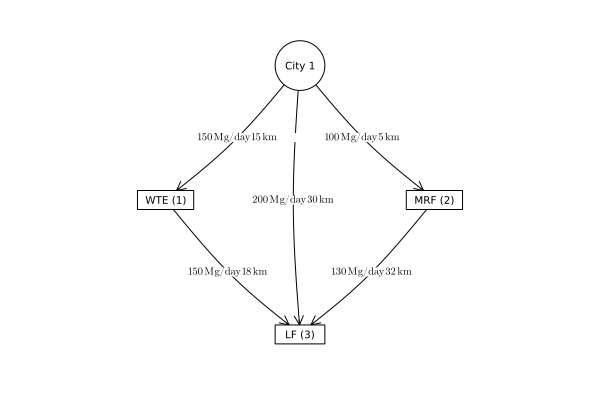

In [39]:
import Pkg; Pkg.add("LaTeXStrings")
using GraphPlot
using LaTeXStrings  # Import for LaTeX formatting in labels

# Adjacency matrix representing the connections
A = [0 1 1 1;  # City 1 connects to MRF, WTE, and LF
     0 0 0 1;  # MRF connects to LF
     0 0 0 1;  # WTE connects to LF
     0 0 0 0]  # LF is a sink node

# Node names
names = ["City 1", "MRF (2)", "WTE (1)", "LF (3)"]

# Edge labels for flows and distances
edge_labels = Dict(
    (1, 2) => L"100 \, \mathrm{Mg/day} \, 5 \, \mathrm{km}",
    (1, 3) => L"150 \, \mathrm{Mg/day} \, 15 \, \mathrm{km}",
    (1, 4) => L"200 \, \mathrm{Mg/day} \, 30 \, \mathrm{km}",
    (2, 4) => L"130 \, \mathrm{Mg/day} \, 32 \, \mathrm{km}",
    (3, 4) => L"150 \, \mathrm{Mg/day} \, 18 \, \mathrm{km}"
)

# Node positions
xpos = [0, 1, -1, 0]
ypos = [2, 1, 1, 0]

# Node shapes
shapes = [:ellipse, :rect, :rect, :rect]

# Plotting the graph
p = graphplot(
    A,
    names=names,
    edgelabel=edge_labels,
    markersize=0.15,
    markershapes=shapes,
    markercolor=:white,
    x=xpos,
    y=ypos
)
display(p)

## References

List any external references consulted, including classmates.